## Imports

In [55]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from datatile.summary.df import DataFrameSummary
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [56]:
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib
from sklearn.metrics import roc_curve, roc_auc_score

This is a fictional data set created by IBM data scientists to explore attrition and employee retention rates, usually this is data that would be gathered by the Human resources department.

In [57]:
# ref: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset
ec_df = pd.read_csv('./WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [58]:
ec_df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [59]:
ec_df.shape

(1470, 35)

### Preprocessing pipeline

In [60]:
#Getting the columns that are categorical and the ones that are numerical
columns = ec_df.columns

In [61]:
categorical_columns = []
numerical_columns = []
for i in columns:
    if ec_df[i].dtype == 'object':
        categorical_columns.append(i)
    else:
        numerical_columns.append(i)

In [68]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
numeric_pipeline = Pipeline(steps = [('num_imputer',SimpleImputer(strategy='median')),('scaler',MinMaxScaler())])
category_pipeline = Pipeline(steps = [('cat_imputer',SimpleImputer(strategy='most_frequent')),('encoder',OneHotEncoder(handle_unknown='error',drop='first'))])
#Creating a transformer pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
preprocessing = ColumnTransformer(transformers= [('num',numeric_pipeline, make_column_selector(dtype_exclude='object')),
                                               ('cat',category_pipeline, make_column_selector(dtype_include='object')),])

In [69]:
X = ec_df.drop('Attrition',axis =1 )
y = ec_df['Attrition']

In [70]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.3, stratify=y,random_state=100)

### Baseline Models

### Decision Tree Classifier

In [71]:
from sklearn.tree import DecisionTreeClassifier
dec_clf = DecisionTreeClassifier()
dec_pipe = Pipeline(steps = [('preprocessing',preprocessing),('model',dec_clf)])

In [72]:
dec_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90f1022970>),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
 

In [73]:
temp = y_val.apply(lambda x: 1 if x=='Yes' else 0)

In [74]:
from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score
train_preds = dec_pipe.predict(X_train)
val_preds = dec_pipe.predict(X_val)

train_preds_proba = dec_pipe.predict_proba(X_train)
val_preds_proba = dec_pipe.predict_proba(X_val)

print('Training & Validation ROC AUC Scores:\n', '-'*40)
print('Training   roc auc score= {:.4f}'.format(roc_auc_score(y_train, train_preds_proba[:, 1])))
print('Validation roc auc score= {:.4f}'.format(roc_auc_score(y_val, val_preds_proba[:, 1])))
print('')
print('Training & Validation Confusion Metrices:')
print('Training   confusion matrix:\n', confusion_matrix(y_train, train_preds))
print('Validation confusion matrix:\n', confusion_matrix(y_val, val_preds))
print('Training Accuracy of the model:\n',accuracy_score(y_train,train_preds))
print('Testing Accuracy of the model:\n',round(accuracy_score(y_val,val_preds),4))
false_positive_rate_dec, true_positive_rate_dec, threshold1_dec = roc_curve(temp, val_preds_proba[:, 1])

Training & Validation ROC AUC Scores:
 ----------------------------------------
Training   roc auc score= 1.0000
Validation roc auc score= 0.5728

Training & Validation Confusion Metrices:
Training   confusion matrix:
 [[863   0]
 [  0 166]]
Validation confusion matrix:
 [[304  66]
 [ 48  23]]
Training Accuracy of the model:
 1.0
Testing Accuracy of the model:
 0.7415


### Hyper-parameter tuning for DecisionTreesClassifier

In [75]:
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
start = time.time()
parameters = {'model__criterion':['gini','entropy'],'model__max_depth':[2,4,6,8],'model__min_samples_split':[2,3,4]}
clf=GridSearchCV(dec_pipe,parameters,scoring='roc_auc',n_jobs = -1)
clf.fit(X_train, y_train)
print(clf.best_params_)
predicted=clf.predict(X_val)
proba = clf.predict_proba(X_val)
print('Train Accuracy of the model after hyperparameter tuning')
print(round(accuracy_score(y_train, clf.predict(X_train)),4))
print('Test Accuracy of the model after hyperparameter tuning')
print(round(accuracy_score(y_val, predicted),4))
print('AUC Score of the Train data is:')
print(round(roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]),4))
print('AUC Score of the Test data is:')
print(round(roc_auc_score(y_val, proba[:, 1]),4))
false_positive_rate_dec_hyper, true_positive_rate_dec_hyper, threshold1_dec_hyper = roc_curve(temp, proba[:, 1])
end = time.time()
print('Execution time is:')
print(end - start)

{'model__criterion': 'entropy', 'model__max_depth': 2, 'model__min_samples_split': 2}
Train Accuracy of the model after hyperparameter tuning
0.8542
Test Accuracy of the model after hyperparameter tuning
0.8277
AUC Score of the Train data is:
0.7372
AUC Score of the Test data is:
0.6902
Execution time is:
0.6683580875396729


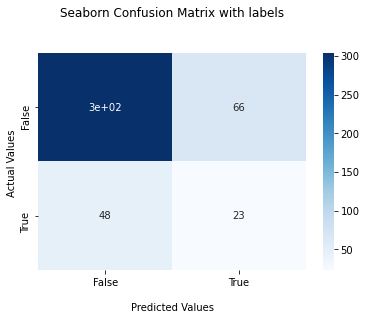

In [76]:
import seaborn as sns

ax = sns.heatmap(confusion_matrix(y_val, val_preds), annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

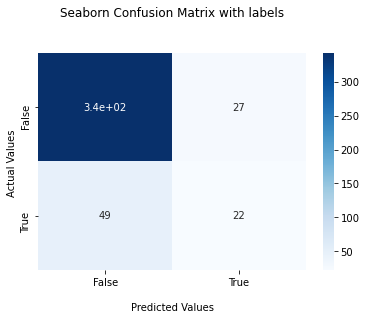

In [77]:
ax = sns.heatmap(confusion_matrix(y_val, clf.predict(X_val)), annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

### KNN

In [78]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_pipe = Pipeline(steps = [('preprocessing',preprocessing),('model',knn_clf)])

In [79]:
knn_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90f1022970>),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
 

In [80]:
from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score
train_preds = knn_pipe.predict(X_train)
val_preds = knn_pipe.predict(X_val)

train_preds_proba = knn_pipe.predict_proba(X_train)
val_preds_proba = knn_pipe.predict_proba(X_val)

print('Training & Validation ROC AUC Scores:\n', '-'*40)
print('Training   roc auc score= {:.4f}'.format(roc_auc_score(y_train, train_preds_proba[:, 1])))
print('Validation roc auc score= {:.4f}'.format(roc_auc_score(y_val, val_preds_proba[:, 1])))
print('')
print('Training & Validation Confusion Metrices:')
print('Training   confusion matrix:\n', confusion_matrix(y_train, train_preds))
print('Validation confusion matrix:\n', confusion_matrix(y_val, val_preds))
print('Training Accuracy of the model:\n',round(accuracy_score(y_train,train_preds),4))
print('Testing Accuracy of the model:\n',round(accuracy_score(y_val,val_preds),4))
false_positive_rate_knn, true_positive_rate_knn, threshold1_knn = roc_curve(temp, val_preds_proba[:, 1])

Training & Validation ROC AUC Scores:
 ----------------------------------------
Training   roc auc score= 0.8949
Validation roc auc score= 0.6546

Training & Validation Confusion Metrices:
Training   confusion matrix:
 [[851  12]
 [120  46]]
Validation confusion matrix:
 [[365   5]
 [ 61  10]]
Training Accuracy of the model:
 0.8717
Testing Accuracy of the model:
 0.8503


### Hyper-parameter tuning for KNN

In [81]:
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
start = time.time()
parameters = {'model__n_neighbors':[3,5,10,15,20],'model__weights':['uniform','distance'],'model__metric':['euclidean','manhattan']}
clf=GridSearchCV(knn_pipe,parameters,scoring='roc_auc',n_jobs = -1)
clf.fit(X_train, y_train)
print(clf.best_params_)
predicted=clf.predict(X_val)
proba = clf.predict_proba(X_val)
print('Train Accuracy of the model after hyperparameter tuning')
print(round(accuracy_score(y_train, clf.predict(X_train)),4))
print('Test Accuracy of the model after hyperparameter tuning')
print(round(accuracy_score(y_val, predicted),4))
print('AUC Score of the Train data is:')
print(round(roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]),4))
print('AUC Score of the Test data is:')
print(round(roc_auc_score(y_val, proba[:, 1]),4))
false_positive_rate_knn_hyper, true_positive_rate_knn_hyper, threshold1_knn_hyper = roc_curve(temp, proba[:, 1])
end = time.time()
print('Execution time is:')
print(end - start)

{'model__metric': 'manhattan', 'model__n_neighbors': 20, 'model__weights': 'uniform'}
Train Accuracy of the model after hyperparameter tuning
0.8494
Test Accuracy of the model after hyperparameter tuning
0.8413
AUC Score of the Train data is:
0.8436
AUC Score of the Test data is:
0.769
Execution time is:
0.7196700572967529


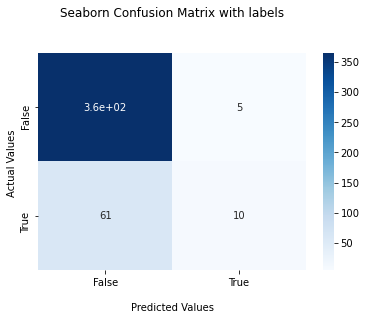

In [85]:
import seaborn as sns

ax = sns.heatmap(confusion_matrix(y_val, val_preds), annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

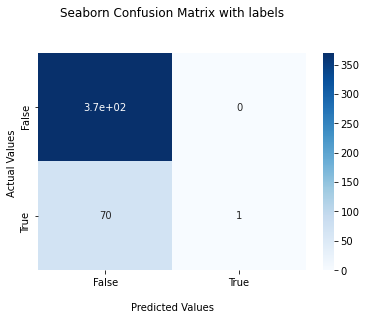

In [86]:
ax = sns.heatmap(confusion_matrix(y_val, clf.predict(X_val)), annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

### Ensemble Models

#### Random Forest Classifier

In [87]:
from sklearn.ensemble import RandomForestClassifier
rand_clf = RandomForestClassifier()
rand_pipe = Pipeline(steps = [('preprocessing',preprocessing),('model',rand_clf)])

In [88]:
rand_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90f1022970>),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
 

In [89]:
from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score
train_preds = rand_pipe.predict(X_train)
val_preds = rand_pipe.predict(X_val)

train_preds_proba = rand_pipe.predict_proba(X_train)
val_preds_proba = rand_pipe.predict_proba(X_val)

print('Training & Validation ROC AUC Scores:\n', '-'*40)
print('Training   roc auc score= {:.4f}'.format(roc_auc_score(y_train, train_preds_proba[:, 1])))
print('Validation roc auc score= {:.4f}'.format(roc_auc_score(y_val, val_preds_proba[:, 1])))
print('')
print('Training & Validation Confusion Metrices:')
print('Training   confusion matrix:\n', confusion_matrix(y_train, train_preds))
print('Validation confusion matrix:\n', confusion_matrix(y_val, val_preds))
print('Training Accuracy of the model:\n',round(accuracy_score(y_train,train_preds),4))
print('Testing Accuracy of the model:\n',round(accuracy_score(y_val,val_preds),4))
false_positive_rate_random, true_positive_rate_random, threshold1_random = roc_curve(temp, val_preds_proba[:, 1])

Training & Validation ROC AUC Scores:
 ----------------------------------------
Training   roc auc score= 1.0000
Validation roc auc score= 0.8199

Training & Validation Confusion Metrices:
Training   confusion matrix:
 [[863   0]
 [  0 166]]
Validation confusion matrix:
 [[368   2]
 [ 63   8]]
Training Accuracy of the model:
 1.0
Testing Accuracy of the model:
 0.8526


### Hyperparameter tuning for Random Forest Classifier

In [90]:
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
start = time.time()
parameters = {'model__n_estimators':[3,5,7,10,15],'model__max_depth':[5,10,None],'model__max_features':['auto','sqrt','log2']}
clf=GridSearchCV(rand_pipe,parameters,scoring='roc_auc',n_jobs = -1)
clf.fit(X_train, y_train)
print(clf.best_params_)
predicted=clf.predict(X_val)
proba = clf.predict_proba(X_val)
print('Train Accuracy of the model after hyperparameter tuning')
print(round(accuracy_score(y_train, clf.predict(X_train)),4))
print('Test Accuracy of the model after hyperparameter tuning')
print(round(accuracy_score(y_val, predicted),4))
print('AUC Score of the Train data is:')
print(round(roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]),4))
print('AUC Score of the Test data is:')
print(round(roc_auc_score(y_val, proba[:, 1]),4))
end = time.time()
false_positive_rate_random_hyper, true_positive_rate_random_hyper, threshold1_random_hyper = roc_curve(temp, proba[:, 1])
print('Execution time is:')
print(end - start)

{'model__max_depth': 5, 'model__max_features': 'log2', 'model__n_estimators': 15}
Train Accuracy of the model after hyperparameter tuning
0.8678
Test Accuracy of the model after hyperparameter tuning
0.8503
AUC Score of the Train data is:
0.9177
AUC Score of the Test data is:
0.8067
Execution time is:
1.431257724761963


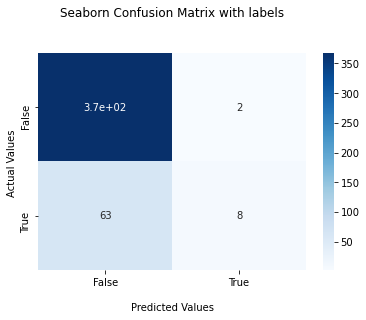

In [91]:
ax = sns.heatmap(confusion_matrix(y_val, val_preds), annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

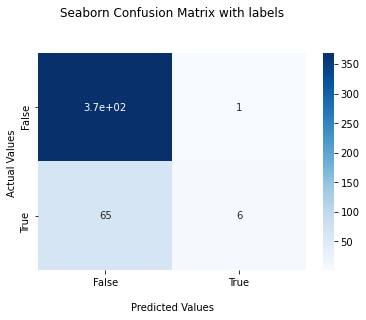

In [92]:
ax = sns.heatmap(confusion_matrix(y_val, clf.predict(X_val)), annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticke`t labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

### Adaboost Classifier

In [93]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier()
ada_pipe = Pipeline(steps = [('preprocessing',preprocessing),('model',ada_clf)])

In [94]:
ada_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90f1022970>),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
 

In [95]:
from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score
train_preds = ada_pipe.predict(X_train)
val_preds = ada_pipe.predict(X_val)

train_preds_proba = ada_pipe.predict_proba(X_train)
val_preds_proba = ada_pipe.predict_proba(X_val)

print('Training & Validation ROC AUC Scores:\n', '-'*40)
print('Training   roc auc score= {:.4f}'.format(roc_auc_score(y_train, train_preds_proba[:, 1])))
print('Validation roc auc score= {:.4f}'.format(roc_auc_score(y_val, val_preds_proba[:, 1])))
print('')
print('Training & Validation Confusion Metrices:')
print('Training   confusion matrix:\n', confusion_matrix(y_train, train_preds))
print('Validation confusion matrix:\n', confusion_matrix(y_val, val_preds))
print('Training Accuracy of the model:\n',round(accuracy_score(y_train,train_preds),4))
print('Testing Accuracy of the model:\n',round(accuracy_score(y_val,val_preds),4))
false_positive_rate_ada, true_positive_rate_ada, threshold1_ada = roc_curve(temp, val_preds_proba[:,1])

Training & Validation ROC AUC Scores:
 ----------------------------------------
Training   roc auc score= 0.9323
Validation roc auc score= 0.7947

Training & Validation Confusion Metrices:
Training   confusion matrix:
 [[845  18]
 [ 79  87]]
Validation confusion matrix:
 [[350  20]
 [ 41  30]]
Training Accuracy of the model:
 0.9057
Testing Accuracy of the model:
 0.8617


### Hyperparameter tuning for AdaBoost

In [96]:
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
start = time.time()
parameters = {'model__n_estimators':[5,10,50,100,500]}
clf=GridSearchCV(ada_pipe,parameters,scoring='roc_auc',cv=7,n_jobs = -1)
clf.fit(X_train, y_train)
print(clf.best_params_)
predicted=clf.predict(X_val)
proba = clf.predict_proba(X_val)
print('Train Accuracy of the model after hyperparameter tuning')
print(round(accuracy_score(y_train, clf.predict(X_train)),4))
print('Test Accuracy of the model after hyperparameter tuning')
print(round(accuracy_score(y_val, predicted),4))
print('AUC Score of the Train data is:')
print(round(roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]),4))
print('AUC Score of the Test data is:')
print(round(roc_auc_score(y_val, proba[:, 1]),4))
false_positive_rate_ada_hyper, true_positive_rate_ada_hyper, threshold1_ada_hyper = roc_curve(temp, proba[:, 1])
end = time.time()
print('Execution time is:')
print(end - start)

{'model__n_estimators': 50}
Train Accuracy of the model after hyperparameter tuning
0.9057
Test Accuracy of the model after hyperparameter tuning
0.8617
AUC Score of the Train data is:
0.9323
AUC Score of the Test data is:
0.7947
Execution time is:
2.833677053451538


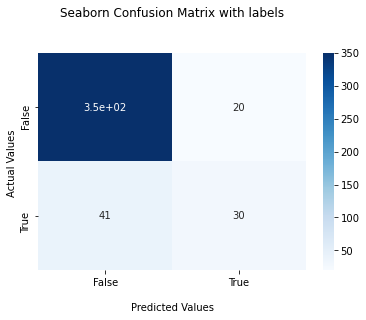

In [97]:
ax = sns.heatmap(confusion_matrix(y_val, val_preds), annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

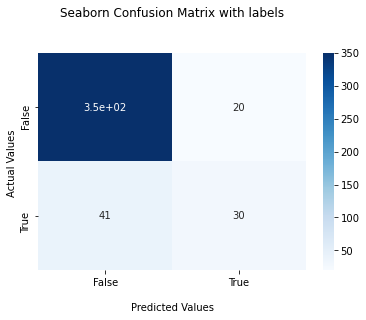

In [98]:
ax = sns.heatmap(confusion_matrix(y_val, clf.predict(X_val)), annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticke`t labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

### Support Vector Machines

In [99]:
from sklearn.svm import SVC
svm_clf = SVC(probability=True)
svm_pipe = Pipeline(steps = [('preprocessing',preprocessing),('model',svm_clf)])

In [100]:
svm_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90f1022970>),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
 

In [101]:
from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score
train_preds = svm_pipe.predict(X_train)
val_preds = svm_pipe.predict(X_val)

train_preds_proba = svm_pipe.predict_proba(X_train)
val_preds_proba = svm_pipe.predict_proba(X_val)

print('Training & Validation ROC AUC Scores:\n', '-'*40)
print('Training   roc auc score= {:.4f}'.format(roc_auc_score(y_train, train_preds_proba[:, 1])))
print('Validation roc auc score= {:.4f}'.format(roc_auc_score(y_val, val_preds_proba[:, 1])))
print('')
print('Training & Validation Confusion Metrices:')
print('Training   confusion matrix:\n', confusion_matrix(y_train, train_preds))
print('Validation confusion matrix:\n', confusion_matrix(y_val, val_preds))
print('Training Accuracy of the model:\n',round(accuracy_score(y_train,train_preds),4))
print('Testing Accuracy of the model:\n',round(accuracy_score(y_val,val_preds),4))
false_positive_rate_svm, true_positive_rate_svm, threshold1_svm = roc_curve(temp, val_preds_proba[:,1])

Training & Validation ROC AUC Scores:
 ----------------------------------------
Training   roc auc score= 0.9587
Validation roc auc score= 0.8324

Training & Validation Confusion Metrices:
Training   confusion matrix:
 [[863   0]
 [115  51]]
Validation confusion matrix:
 [[370   0]
 [ 65   6]]
Training Accuracy of the model:
 0.8882
Testing Accuracy of the model:
 0.8526


### Hyperparameter tuning for Support Vector Machines 

In [102]:
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
start = time.time()
parameters = {'model__C':[0.1, 1, 10, 100, 1000],'model__gamma':[1, 0.1, 0.01, 0.001, 0.0001]}
clf=GridSearchCV(svm_pipe,parameters,scoring='roc_auc',cv=3,n_jobs = -1)
clf.fit(X_train, y_train)
print(clf.best_params_)
predicted=clf.predict(X_val)
proba = clf.predict_proba(X_val)
print('Train Accuracy of the model after hyperparameter tuning')
print(round(accuracy_score(y_train, clf.predict(X_train)),4))
print('Test Accuracy of the model after hyperparameter tuning')
print(round(accuracy_score(y_val, predicted),4))
print('AUC Score of the Train data is:')
print(round(roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]),4))
print('AUC Score of the Test data is:')
print(round(roc_auc_score(y_val, proba[:, 1]),4))
false_positive_rate_svm_hyper, true_positive_rate_svm_hyper, threshold1_svm_hyper = roc_curve(temp, proba[:, 1])
end = time.time()
print('Execution time is:')
print(end - start)

{'model__C': 100, 'model__gamma': 0.01}
Train Accuracy of the model after hyperparameter tuning
0.9155
Test Accuracy of the model after hyperparameter tuning
0.8912
AUC Score of the Train data is:
0.91
AUC Score of the Test data is:
0.8509
Execution time is:
2.6482319831848145


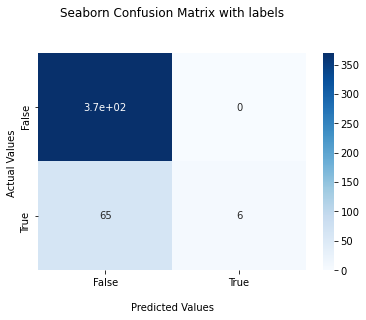

In [103]:
ax = sns.heatmap(confusion_matrix(y_val, val_preds), annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

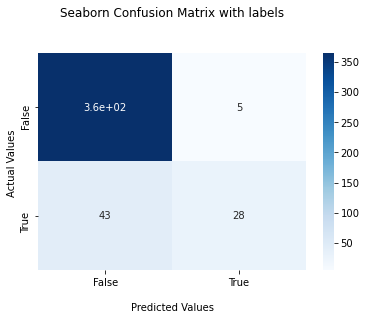

In [104]:
ax = sns.heatmap(confusion_matrix(y_val, clf.predict(X_val)), annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticke`t labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

### ROC Curves

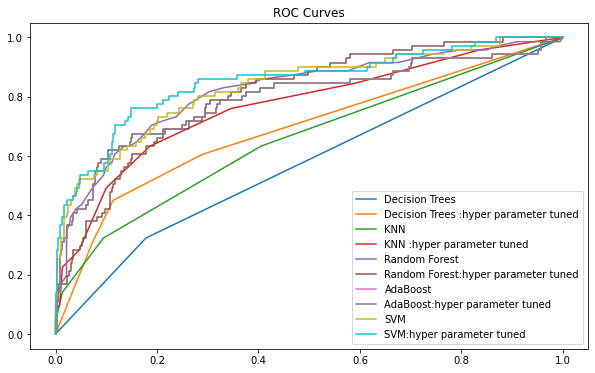

In [105]:
plt.figure(figsize=(10, 6))
plt.plot(false_positive_rate_dec, true_positive_rate_dec,Label = 'Decision Trees')
plt.plot(false_positive_rate_dec_hyper, true_positive_rate_dec_hyper,Label = 'Decision Trees :hyper parameter tuned')
plt.plot(false_positive_rate_knn, true_positive_rate_knn,Label = 'KNN')
plt.plot(false_positive_rate_knn_hyper, true_positive_rate_knn_hyper,Label = 'KNN :hyper parameter tuned')
plt.plot(false_positive_rate_random, true_positive_rate_random,Label = 'Random Forest')
plt.plot(false_positive_rate_random_hyper, true_positive_rate_random_hyper,Label = 'Random Forest:hyper parameter tuned')
plt.plot(false_positive_rate_ada, true_positive_rate_ada,Label = 'AdaBoost')
plt.plot(false_positive_rate_ada_hyper, true_positive_rate_ada_hyper,Label = 'AdaBoost:hyper parameter tuned')
plt.plot(false_positive_rate_svm, true_positive_rate_svm,Label = 'SVM')
plt.plot(false_positive_rate_svm_hyper, true_positive_rate_svm_hyper,Label = 'SVM:hyper parameter tuned')
plt.title('ROC Curves')
plt.legend()
plt.show()